In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.06G/2.06G [01:35<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2


Trying to read: /root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data/train/COVID19/COVID19(7).jpg
Trying to read: /root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data/train/NORMAL/NORMAL(99).jpg
Trying to read: /root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data/train/PNEUMONIA/PNEUMONIA(997).jpg


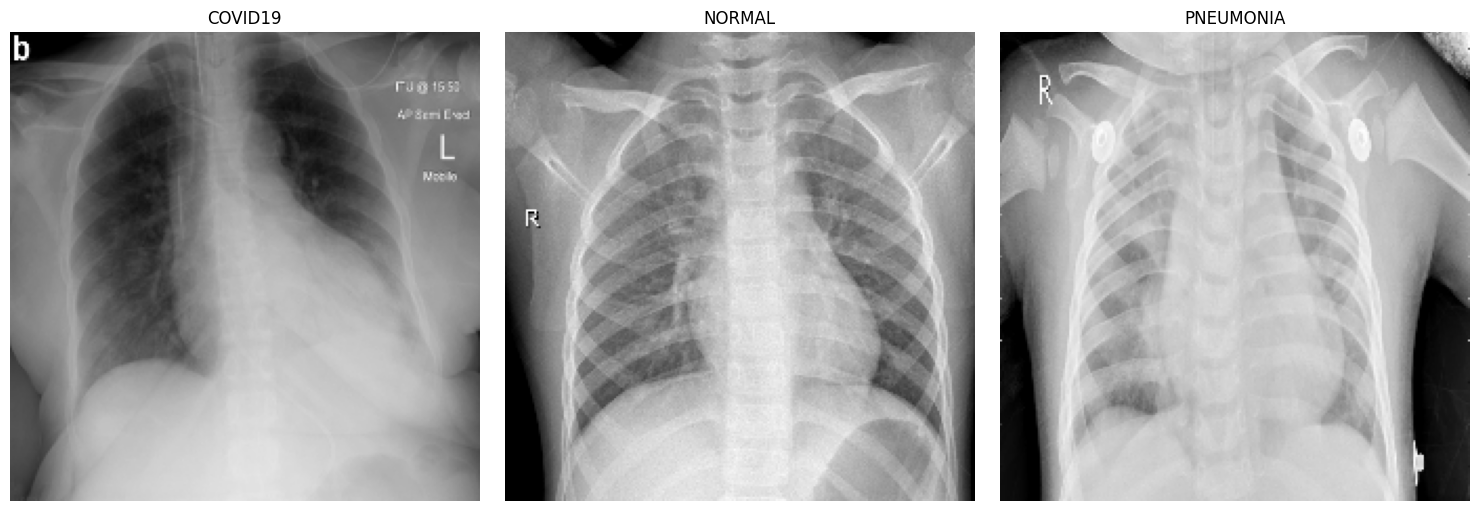

In [ ]:
data_dir = os.path.join(path, "Data", "train")  # e.g. "/.../Data/train"

categories = ['COVID19', 'NORMAL', 'PNEUMONIA']

images_path = [
    'COVID19/COVID19(7).jpg',
    'NORMAL/NORMAL(99).jpg',
    'PNEUMONIA/PNEUMONIA(997).jpg',
]

# Plot 3 images (one from each folder)
plt.figure(figsize=(15, 5))

for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    # Build the full path to the image file
    img_path = os.path.join(data_dir, images_path[i])
    print("Trying to read:", img_path)  # for debugging

    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        continue

    # Resize and convert for plotting
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.imshow(img)
    plt.title(categories[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_dir = os.path.join(path, 'Data', 'train')
test_dir  = os.path.join(path, 'Data', 'test')

# Function to clean the dataset
def clean_dataset(folder_path, categories):
    cleaned_images = 0
    removed_images = 0

    for category in categories:
        category_path = os.path.join(folder_path, category)  # e.g., "train/PNEUMONIA"

        for filename in os.listdir(category_path):  # Loop through all images in the category folder
            file_path = os.path.join(category_path, filename)

            # Try to read the image
            img = cv2.imread(file_path)

            if img is None or img.shape[0] < 50 or img.shape[1] < 50:
                # If the image is unreadable or too small, remove it
                os.remove(file_path)
                removed_images += 1
            else:
                cleaned_images += 1

    print(f"Cleaning Complete: {cleaned_images} valid images kept, {removed_images} removed.")

# Run the cleaning function
clean_dataset(train_dir, categories)

Cleaning Complete: 5144 valid images kept, 0 removed.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Augmentation (same as yours — effective!)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# checking for imbalance classes
from collections import Counter
labels = train_gen.classes  # These are the labels for each image
label_counts = Counter(labels)
print("Class distribution:", label_counts)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4116 images belonging to 3 classes.
Class distribution: Counter({np.int32(2): 2735, np.int32(1): 1013, np.int32(0): 368})
Found 1028 images belonging to 3 classes.


In [ ]:
# As the dataset is imbalanced

from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("✅ Class Weights:", class_weights)


✅ Class Weights: {0: np.float64(3.7282608695652173), 1: np.float64(1.3543928923988153), 2: np.float64(0.5016453382084095)}


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),     # increased from 128 → 256
    layers.Dropout(0.2),                      # reduced from 0.3 → 0.2
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # Watch validation loss
    factor=0.5,               # Reduce LR by 50%
    patience=2,               # Wait 2 epochs before reducing
    verbose=1,
    min_lr=1e-6               # Never go below this
)

# 🚫 No class_weight for now!
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=7,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights
)


Epoch 1/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 88s 644ms/step - accuracy: 0.6039 - loss: 6.5556 - val_accuracy: 0.0895 - val_loss: 69.4422 - learning_rate: 0.0010
Epoch 2/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 588ms/step - accuracy: 0.6886 - loss: 0.7591 - val_accuracy: 0.3181 - val_loss: 33.4514 - learning_rate: 0.0010
Epoch 3/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 77s 598ms/step - accuracy: 0.7015 - loss: 0.7011 - val_accuracy: 0.6780 - val_loss: 5.6938 - learning_rate: 0.0010
Epoch 4/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 81s 629ms/step - accuracy: 0.7602 - loss: 0.5788 - val_accuracy: 0.6440 - val_loss: 2.5135 - learning_rate: 0.0010
Epoch 5/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 75s 583ms/step - accuracy: 0.7746 - loss: 0.5253 - val_accuracy: 0.3132 - val_loss: 3.0810 - learning_rate: 0.0010
Epoch 6/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 587ms/step - accuracy: 0.7294 - loss: 0.6700 - val_accuracy: 0.3395 - val_loss: 1.5973 - learning_rate: 0.0010
Epoch 7/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 75s 578ms/step - accuracy: 0.8029 -

In [ ]:
# ✅ Evaluate
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_gen)
print("✅ Test Loss:", test_loss)
print("✅ Test Accuracy:", test_acc)


Found 1288 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 291ms/step - accuracy: 0.7000 - loss: 0.6426
✅ Test Loss: 1.0657453536987305
✅ Test Accuracy: 0.425465852022171


In [ ]:
# 📊 Plot Curves
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()
